# <center> 🎩✨ Продвинутый feature engeneering </center>

<img src='../images/cbemb.png' align="right" width=800>
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Модифицируем MLP на pytorch с двумя головами.  </a></li>

<li><a href="#c2">👩🏾‍🚀 Добываем эмбеддинги</a></li>
<li><a href="#с3">📲 Эмбеддинги + CatBoost </a>
<li><a href="#c4">🧠 Мысли и выводы</a>

</li></ul></font></p>

<div class="alert alert-info">

В этом уроке разберём как вытащить эмбеддинги из нейронки и подать их в бустинг. <br>
И узнаем, сможет ли такой подход побить скор самой нейронки?

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

In [52]:
# Загружаем train-датасет, который мы сохранили на шаге quickstart
rides_info = pd.read_csv('../data/quickstart_train.csv')
rides_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [53]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

In [54]:
# закодируем категориальные фичи в one hot encoding вектора
rides_info = pd.get_dummies(rides_info, columns=cat_cols)

In [55]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

/tmp/ipykernel_110302/2067634496.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rides_info.fillna(rides_info.median(), inplace=True)


# <center>🛠 Модифицируем `MLP` на `PyTorch` с двумя головами.</center> 

Возьмем реализацию `MLP` с двумя головами на `PyTorch` из предыдущего ноутбука и модифицируем её.

In [56]:
# переведем строковые значения категориального таргета в целочисленные
le = LabelEncoder()
rides_info['target_class'] = le.fit_transform(rides_info['target_class'])

In [57]:
# числовые переменные, которые подвергнем трансформации
num_cols = [col for col in list(rides_info.columns) if col not in drop_cols]

In [58]:
# для нормализации данных используем robust scaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()

target = target_scaler.fit_transform(rides_info['target_reg'].values.reshape(-1, 1))
df['target_reg'] = target
df['target_class'] = rides_info['target_class']

In [60]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [61]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
import copy

In [62]:
# для наших данных и размера нейросети подойдет запуск на cpu
device = torch.device('cpu')

In [63]:
# ВАЖНО! - фиксируем воспроизводимость
def seed_everything(seed=42):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [64]:
# можно попробовать поэкспериментировать с параметрами
class CFG:
    hidden_size=128
    dropout=0.1
    lr=1e-3
    batch_size=128
    num_workers=4
    epochs=20
    num_features=train.shape[1]-2 # кол-во фичей подаваемое на вход
    num_tar_2=train.target_class.nunique() # количество выходов равно кол-ву предсказываемых классов

In [65]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        
        data = row.drop(labels=['target_reg', 'target_class'])
        
        data = torch.FloatTensor(data.values.astype('float'))
        tar_1 = torch.tensor(row['target_reg']).float()
        tar_2 = row['target_class'].astype('int')
        
        return data, tar_1, tar_2

In [66]:
# проверим корректность работы методов нашего класса
next(iter(Rides(train)))

(tensor([-0.7302, -1.5000, -1.4019,  1.0000,  0.2215, -0.1615, -0.1000,  0.4241,
         -0.2246,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]),
 tensor(-0.6091),
 2)

In [67]:
dataset = Rides(df)
dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=CFG.batch_size, 
                                        shuffle=False, 
                                        num_workers=CFG.num_workers)

In [68]:
# Построим архитектуру mlp с двумя головами для регрессии и классифкации

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(cfg.num_features, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
                          )
        
        self.regressor = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, cfg.num_tar_2)
        )

    def forward(self, data):
        x = self.mlp(data) # здесь эмбеддинги
        tar1 = self.regressor(x) # здесь предсказания
        tar2 = self.classifier(x)
        return x  # оставляем только выход с линейных слоев - эмбеддинги

## Возьмем сохраненные веса модели из предыдущего ноутбука и модифицируем архитектуру нейросети для извлечения эмбеддингов.

In [69]:
# Загружаем, сохранённые ранее, веса модели
model = TabularNN(CFG)
PATH = 'tab_model.pth'
model.load_state_dict(torch.load(PATH))

# Обычно, для получения эмбеддингов, финальные слои заменяют на nn.Identity()
# В нашем случае, это делать необязательно
model.classifier = torch.nn.Identity()
model.regressor = torch.nn.Identity()
model.to(device)
model.eval()

TabularNN(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Identity()
  (classifier): Identity()
)

# <center> 👩🏾‍🚀 Добываем эмбеддинги. </center>

In [70]:
# Собираем эмбеддинги в список
embeddings = []

with torch.no_grad():
    for inputs, labels_1, labels_2 in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        embeddings.extend(outputs.detach().cpu().numpy())

In [71]:
# Преобразуем list в датафрейм с эмбеддингами
embed_df = pd.DataFrame(data=embeddings, 
                        columns=[f'embed_{i}' for i in range(embeddings[0].shape[0])])
embed_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.111090,1.831399,1.029137,-1.281515,0.127552,0.401121,-0.720918,-2.080181,0.998112,1.505967,...,-0.381980,-3.162806,0.842893,-1.344295,-2.987895,2.126354,0.447995,-0.093849,0.805080,0.160024
1,0.720988,5.125418,0.924420,-1.869206,-0.603578,-1.718873,1.624190,-2.385734,0.292822,-0.466737,...,-1.147222,-5.069707,-3.510749,-1.756007,-4.315677,1.399842,0.626463,-1.450504,1.477612,-0.517914
2,0.911851,-3.371108,-3.725893,3.699695,1.001278,4.190698,-0.368721,2.045195,0.019778,1.626086,...,2.983720,5.228241,7.594233,5.968011,2.425908,-0.390065,-1.484127,5.817946,0.465308,-2.598303
3,1.298770,4.335648,-0.348417,0.847484,-1.030737,-1.439776,2.333208,-1.944929,-0.223670,-1.358776,...,-1.456223,-3.941442,-1.828998,-1.200647,-2.254383,0.425059,-0.484277,0.826269,2.573339,-0.769658
4,0.936428,5.241862,1.210827,-0.956526,-1.116837,-2.046124,1.970339,-2.746303,-0.006629,-1.207323,...,-1.911380,-5.724864,-3.407414,-2.783371,-3.620565,0.992030,0.368925,-1.289734,1.884221,-0.138778


## <center> 📲 Эмбеддинги + `CatBoost` </center>
Добавим эмбеддинги к нашему датасету и попробуем обучить бустинг.

In [73]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [72]:
# Присоединяем эмбединги к трэйн датасету
df = pd.concat((df, embed_df) ,axis=1)
df.head()

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.460317,0.5,0.258414,0.75,0.567305,-0.187985,0.0,0.129562,0.019027,0.0,...,-0.381980,-3.162806,0.842893,-1.344295,-2.987895,2.126354,0.447995,-0.093849,0.805080,0.160024
1,-0.365079,0.5,0.303616,0.75,0.072227,0.841243,-0.1,0.237381,1.085987,0.0,...,-1.147222,-5.069707,-3.510749,-1.756007,-4.315677,1.399842,0.626463,-1.450504,1.477612,-0.517914
2,1.539683,-1.0,-0.903502,-0.25,0.626258,0.465096,0.0,-1.077932,0.235335,0.0,...,2.983720,5.228241,7.594233,5.968011,2.425908,-0.390065,-1.484127,5.817946,0.465308,-2.598303
3,-0.253968,-1.5,-1.389116,0.50,-1.081739,0.575940,0.0,0.005501,-0.419877,0.0,...,-1.456223,-3.941442,-1.828998,-1.200647,-2.254383,0.425059,-0.484277,0.826269,2.573339,-0.769658
4,0.269841,-1.0,-0.835577,-0.25,-0.503927,0.133441,0.0,0.477418,-1.221735,0.0,...,-1.911380,-5.724864,-3.407414,-2.783371,-3.620565,0.992030,0.368925,-1.289734,1.884221,-0.138778


In [74]:
X = df.drop(['target_reg','target_class'], axis=1)
y = df['target_class']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True)

In [77]:
clf.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(clf.get_best_score())

Learning rate set to 0.109335
0:	learn: 1.7774804	test: 1.7933985	best: 1.7933985 (0)	total: 20.5ms	remaining: 20.5s
50:	learn: 0.3845767	test: 0.5953606	best: 0.5953606 (50)	total: 894ms	remaining: 16.6s
100:	learn: 0.3029920	test: 0.5905221	best: 0.5862921 (64)	total: 1.75s	remaining: 15.6s
150:	learn: 0.2441005	test: 0.5979551	best: 0.5862921 (64)	total: 2.64s	remaining: 14.8s
200:	learn: 0.2009457	test: 0.6056219	best: 0.5862921 (64)	total: 3.5s	remaining: 13.9s
250:	learn: 0.1678179	test: 0.6149923	best: 0.5862921 (64)	total: 4.36s	remaining: 13s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5862921314
bestIteration = 64

Shrink model to first 65 iterations.
{'learn': {'MultiClass': 0.16116714498278148}, 'validation': {'MultiClass': 0.5862921314401891}}


In [78]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,rating_min,18.818853
1,embed_5,7.219207
2,embed_58,6.704957
3,embed_46,5.155415
4,embed_22,4.413352
5,embed_37,3.639048
6,embed_61,3.399821
7,embed_63,3.143495
8,speed_max,3.073321
9,embed_27,2.724312


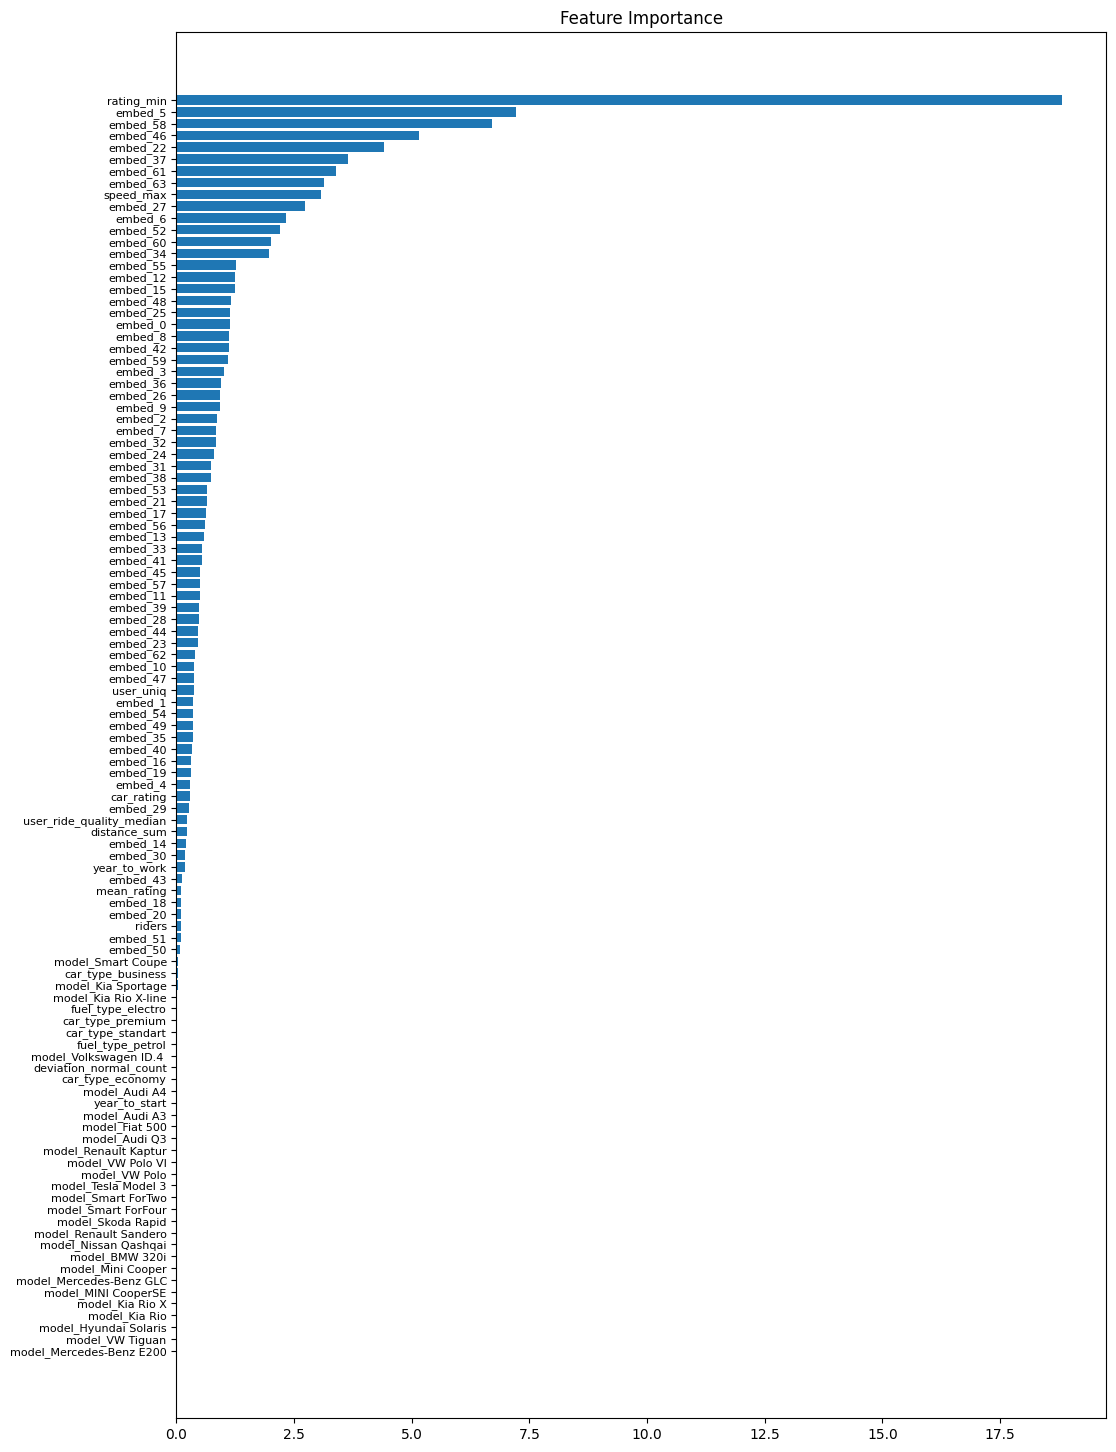

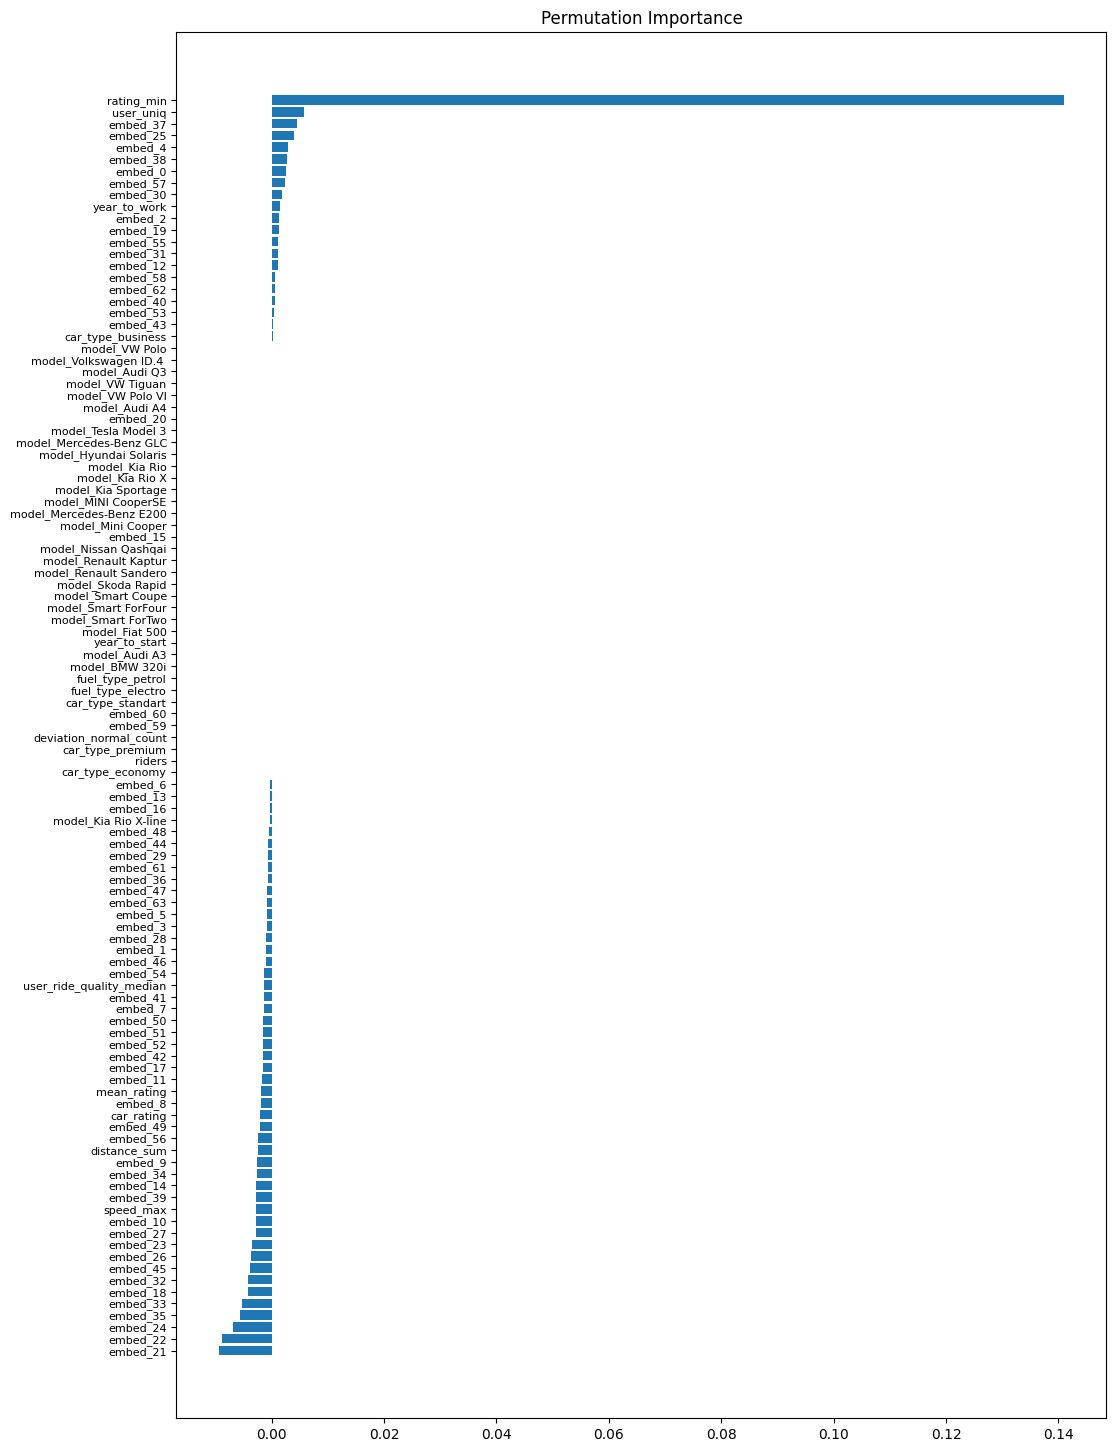

In [79]:
import matplotlib.pyplot as plt

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Feature Importance');

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Permutation Importance');

### Как видно из графиков, эмбеддинги являются сильными признаками

In [50]:
preds = clf.predict(X_test)
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

(0.7723669394817687, 0.7692307692307693)

Скор модели, обученной на эмбеддингах, выше, чем у нейросети

## Регрессия

In [33]:
X = df.drop(['target_reg','target_class'], axis=1)
y = df['target_reg']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
reg = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True)

In [36]:
reg.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(reg.get_best_score())

Learning rate set to 0.056174
0:	learn: 0.7360714	test: 0.7694041	best: 0.7694041 (0)	total: 2.12ms	remaining: 2.12s
50:	learn: 0.4377777	test: 0.5440925	best: 0.5440925 (50)	total: 71.6ms	remaining: 1.33s
100:	learn: 0.4006778	test: 0.5389795	best: 0.5381718 (84)	total: 141ms	remaining: 1.25s
150:	learn: 0.3740091	test: 0.5398906	best: 0.5381718 (84)	total: 207ms	remaining: 1.16s
200:	learn: 0.3475212	test: 0.5426662	best: 0.5381718 (84)	total: 271ms	remaining: 1.08s
250:	learn: 0.3240825	test: 0.5435485	best: 0.5381718 (84)	total: 335ms	remaining: 1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5381718475
bestIteration = 84

Shrink model to first 85 iterations.
{'learn': {'RMSE': 0.3101583599930807}, 'validation': {'RMSE': 0.538171847458068}}


In [37]:
# Посмотрим важность признаков
fi = reg.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,embed_8,31.883415
1,rating_min,13.029656
2,embed_33,4.455324
3,embed_63,4.369812
4,embed_0,2.745084
5,embed_47,2.595474
6,embed_29,2.438609
7,embed_1,2.425039
8,embed_22,2.014274
9,embed_2,1.456371


In [38]:
preds = reg.predict(X_test)

In [39]:
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [40]:
mean_squared_error(y_test, preds) ** 0.5

45.808198136995834

<div class="alert alert-info">

Вернемся к итоговой таблице: видим, что эмбеддинги из нейросети, поданные в `CatBoost`, смогли превзойти точность самой нейросети в задаче классификации. Чтобы ещё увеличить точность, можно потюнить гиперпараметры `CatBoost` или поэкспериментировать с размером эмбеддингов, меняя `hidden_size` или последний слой. Также, можно попробовать получать эмбеддинги с более раннего слоя нейронки или сразу со всех. Вариантов множество!

<center> <img src='../images/nn2.png'> </center>

## <center>🧠 Мысли и выводы</center>


<div class="alert alert-info">

* Эмбеддинги, полученные из нейронной сети, могут поднять скор бустинга выше, чем донорская сеть. Но не всегда!
* Если есть обученная нейросеть под вашу или похожую задачу - стоит попробовать достать из неё эмбеддинги и добавить их к другим фичам.
* Рабочий кейс: посмотреть паблик кернелы соревнования, основанные на нейронках и попробовать достать оттуда эмбеддинги для бустингов.
    
В следующем уроке рассмотрим получение эмбеддингов для тектовых признаков из `BERT трансформера`.